# Regelbaserad identifikation av kapitel i text

#### Principskiss över tillvägagångssätt att extrahera en kapitel från en text 

1. Skär ut innehållsförteckningen 

2. Använd innehållsförteckningen för att identifiera exakt namn på målkapitel och efterföljande kapitel. 

3. Sök sedan i resten av dokumentet för att hitta radnumret för start och stopp. Extrahera innehållet och lägg in i en DataFrame (Pandas) 

 
#### Detaljerade instruktioner 

1. Skär ut innehållsförteckningen 
Detta kan göras på flera sätt men borde inte vara så svårt. Typ sök efter första ”Innehåll*” till och skär av efter typ två sidor.  

2. Identifiera nummer och namn på målkapitel och efterföljande kapitel  
    a. Sök efter målkapitlet med en regexformel och lägg in i en lista med två element. 
    b. Identifiera kapitelnamnet efteråt. Typ genom samma regexformel som för målkapitlet men nu med vad som helst som kapitelnamn. Här kan vi komplettera med if-satser om det skulle behövas. Exempelvis om vi inte hittar något kapitelnummer under målkapitlet så får vi söka efter ”Bilaga” eller ”Appendix”. Och om inget sådant hittas. Lägger vi in ordet ”_Slutkapitel”. 
    c.Om vi inte hittar vårt målkapitel lägger vi in orden ”_inget_målkapitel” på båda namnplatserna och printar namnet på dokumentet i en ny lista som vi får gå igenom manuellt. Antingen måste regex-kommandot kalibreras eller så finns det inget sådant kapitel. 

3. Hitta radstart och radslut för målkapitel (om det finns) och skär ut. Spara i en DataFrame. 
    a. Sök nu igenom resten av dokumentet med kapitelnamnet. Om namnet finns med flera gånger så ska detta flaggas på något sätt. Men valet ska falla på den sista observationen. Samma gäller för efterföljande kapitel som markerar radslutet. 
    b. Spara allt i en DataFrame 

In [176]:
# Importera paket
import os
from itertools import islice
import numpy as np
import pandas as pd
import codecs
import re

#pip install wordcloud
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

#nltk
import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

In [177]:
os.getcwd()

'c:\\Users\\joaki\\OneDrive\\Documents\\Datalab\\Notebooks\\KA_joakim'

In [178]:
path="C:\\Users\\joaki\\OneDrive\\Documents\\Datalab\\Notebooks\\KA_joakim\\Urval_1\\"

In [179]:
# Gör en lista av alla filer i min mapp
list_files=os.listdir(path)
# Kolla de första 10 filerna
print(list_files[0:9])
df_files=pd.DataFrame(list_files, columns=['namn'])
#pd.concat([df_files,pd.DataFrame(columns=['text','tokens','undantag','slutkapitel','relativ_pos'])], sort=False)
df_files['text']=""
df_files['tokens']=""
df_files['undantag']=""
df_files['slutkapitel']=""
df_files['relativ_pos']=""
print(df_files.head())
counter=0


['gz03107.txt', 'gz03108.txt', 'gz03112.txt', 'gz0313.txt', 'gz03133.txt', 'gz03151.txt', 'gz03153.txt', 'gz03158.txt', 'gz03178.txt']
          namn text tokens undantag slutkapitel relativ_pos
0  gz03107.txt                                             
1  gz03108.txt                                             
2  gz03112.txt                                             
3   gz0313.txt                                             
4  gz03133.txt                                             


In [180]:
# En funktion för att tvätta matchade kapitel i innehållsförteckningen
def clean(kap):
    kap=re.sub("\n+"," ",kap)
    kap=kap.replace("(","\(")
    kap=kap.replace(")","\)")
    kap=kap.replace("-","\-")
    kap=kap.strip()
    kap=kap.replace(" ","\s*") # Splittar på witspace
    return kap

#### Kör allt härifrån när du väl är igång

In [186]:
for lpnr in range(0,100):
    print(df_files.iloc[lpnr][0])

    # Använd index för att extrahera
    with open(path+str(df_files.iloc[lpnr][0]), encoding="utf-8", mode='r') as file:
        text=file.read()

    
    ##Hitta målkapitel
    # r.M = MULTILINE söker över fler rader
    # r.I =IGNORECASE
    # ? = not gready. Behövs för att stanna innan punkterna

    #m=re.search('^[ \t]*(\d|1\d)\s+([Kk]onsekvens.*)',text, re.M)
    # Senast fungerande
    _regex='^[ \t]*(\d|1\d)\s+(\s*([åäö\w]+[ \t]+){0,4}konsekvens[åäö\w]+.*?)(?=\.*)'
    m=re.search(_regex,text, re.M + re.I)
    s_flag=-1
    if m!=None:
        df_files.iloc[lpnr][5]=m.span()[0]/len(text)
    # Fixa alla undantag...
    if m==None:
        _regex='(\d.*Statsfinansie.*\s*|.*offentligfinans.*|.*konsekvens.*)'
        m=re.search(_regex,text, re.I)
        try:
            span_cont=m.span()
            print(m)
            df_files.iloc[lpnr,3]=m
            print("--------------------------\nSpeciallösning... kontrollera")
        except AttributeError:
            print("Hittar inget målkapitel... Tar nästa dokument i loop")
            df_files.iloc[lpnr,1]="### Hittar inget målkapitel"
            continue
        flag=lpnr
        df_files.iloc[lpnr,1]="### Speciallösningen måste förbättras"
        continue
    else:
        span_cont=m.span()
        print(m)
        print(m.group(0))
        print(m.group(2))
        print(clean(m.group(2)))
        kap_clean=clean(m.group(2))
        m2=m.group(1)+'[\s|\n\n]+'+kap_clean
        m2_list=re.findall(m2,text, re.M)
        m2_list[-1]
    df_files.iloc[lpnr][5]=m.span()[0]/len(text)
    #Tar ut startpositionen och slutposition för det matchade uttrycket i en lista
    ### Börja här imorgon ###

    displace=span_cont[1]+2000 # Kan göras lite smartare. Typ söka från Kapitel 1 och nedåt.
    print(re.search(m2_list[-1],text[displace:],  re.M + re.I))
    span=re.search(m2_list[-1],text[displace:],  re.M + re.I).span() # Sök från och med efter innehållsförteckningen
    print(span)
    c_1=span[0]+displace
    c_2=span[1]+displace
    print(text[c_1:c_2])

    # Testa om det ser bra ut
    print(text[c_1:c_1+200])
    start_kap=c_1

    ## Hitta efterföljande kapitel
    # Kolla hur det ser ut
    text[span_cont[1]:span_cont[1]+300]

    # Hantera underrubriker. Börja här

    #_regex_s='(\s+\d*\s+\n+)(\d+)([\såäö\w]+.*?)(?=\.*)'
    #_regex_s='(\s+\d*\s+\n+)(\d+)?\.?([\såäö\w]+.*?)(?=\.\.*)' # Funkar för underkapitel
    _regex_s='(\s+\d*\s+\n+)(\d+)?\.?([\såäö\w]+.*?)(?=\.\.*)'
    ms=re.search(_regex_s,text[span_cont[1]:], re.M + re.I)
    print(ms)
    print("-----------")
    print(ms.group(2))
    print("-----------")
    print(ms.group(3))

    print(repr(ms.group(1)))
    print(repr(ms.group(3)))
    print(repr(ms.group(2)))
    print("--------------------")

    # Avgör om efterföljande rad är en bilaga
    if re.match('^Bilaga',ms.group(3)):
        print("Efterföljande kapitel är en bilaga ")
        kk=int(m.group(1))+1
        s_flag=lpnr
        df_files.iloc[lpnr][4]="Bilaga"
    elif re.match('^Utdrag ur protokoll',ms.group(3)):
        print("Efterföljande kapitel är ett protokollutdrag ")
        kk=int(m.group(1))+1
        s_flag=lpnr
        df_files.iloc[lpnr][4]="Protokollutdrag"
    elif ms.group(2)!=None:
        if re.match('\d+',ms.group(2)):
            print("Grupp 2 är en siffra")
            kk=int(ms.group(2))
    elif ms.group(3)==None: 
        print("Grupp 3 finns inte") 
        kk=int(ms.group(2))
    else: 
        print("Grupp 3 finns")
        kk=int(ms.group(3))
    print(kk)   

    #Avgör om efterföljande rad är ett underkapitel
    if int(m.group(1))==kk:
        print(f"Kapitel {kk} har underkapitel")
        kap_nr='('+str(kk+1)+')'
        _regex_s='(\s+\d*\s+\n+)'+kap_nr+'(\s*\w*\s*\w*)(?=\.*)'
        ms=re.search(_regex_s,text[span_cont[1]:], re.M + re.I)
        if ms==None:
            print("Det finns inget kapitel efter sista underkapitlet. Troligen finns här en bilaga eller ett protokollutdrag")
            _regex_b='(^Bilaga\s\d)\s*([^.]+)'
            mb=re.search(_regex_b,text[span_cont[1]:], re.I + re.M)
            print(mb.group(1))
            if re.match('^Bilaga',mb.group(1)):
                print("Efterföljande kapitel är en bilaga ")
                kk=int(m.group(1))+1
                s_flag=lpnr
                df_files.iloc[lpnr][4]="Bilaga efter underrubriker"
                next_kap=mb.group(2)
            else:
                print("Efterföljande kapitel är inte en bilaga. KANSKE ett protokollutdrag. KONTROLLERA")
                #kk=int(m.group(1))+1
                #s_flag=lpnr
                df_files.iloc[lpnr][3]="Något, inte en bilaga, efter underrubriker"
                next_kap=mb.group(0)
                break
        else:
            print(ms)
            print(ms.group(2))
            print("---------")
            print(ms.group(3))    
    else:
        print(f"Kapitel {kk} har inga subkapitel som behöver hanteras")
        kap_nr=kk
    
    if ms==None:
        print("ms finns ej. Trolligen en bilaga av nått slag")
    else:
        next_kap=ms.group(3) ## EVENTUELLT ETT PROBLEM
   

    #Använd funktionen och rensa. Kolla att det blir rätt
    next_kap=clean(next_kap)
    print(repr(next_kap))

    if s_flag==lpnr:
        print("Efterföljande kapitel är en Bilaga eller ett protokollutdrag. Ingen behandling av kapitelnummer behövs.\n")
        ms2=next_kap
    else: 
        ms2=ms.group(2)+'\s*'+next_kap

    print(ms2)
    ms2_list=re.findall(ms2,text, re.M)
    displace=span_cont[1]+1000
    ms2_s=re.search(ms2,text[displace:], re.M)
    print(ms2_list)
    print(ms2_s)

    # Tar bort "Bilaga #" och använder bara rubriken till Bilaga #
    if ms2_s==None:
        _regex_b='(^Bilaga\s\d)\s*([^.]+)'
        mb=re.search(_regex_b,text[span_cont[1]:], re.I + re.M)
        print(mb)
        x=mb.group(2)
        print(x)
        ms2_sx=re.search(clean(x),text[displace:], re.M)
        print(ms2_sx)
        ms2_s=ms2_sx
        ms2_list=re.findall(ms2,text, re.M)
        print(ms2_list)
        counter=counter+1

    #Kontrollera att det är rätt ms2_s.start():ms2_s.end()+500
    correct=ms2_s.start()+displace
    print(text[correct:correct+1000])
    stop=correct

    # Klipp ut kapitlet
    kap=text[start_kap:stop]
    #print(kap)

    ##################################################
    df_files.iloc[lpnr,1]=kap
    df_files.iloc[lpnr,2]=len(word_tokenize(kap))
    my_dir=['m2_list','m2','flag','kap','kap_clean','kap_nr','kk','m','mb','ms','ms2','ms2_list','ms2_s','ms2_sx','next_kap','s_flag','span','span_cont','start_kap','stop','x']
    for varis in dir():
        if varis in my_dir and varis != "my_dir":
            del locals()[varis]
            print("deleting temporary variable: " +varis)
    # End loop

###############################################################    

df_files.head(20)


ing temporary variable: ms2_list
deleting temporary variable: ms2_s
deleting temporary variable: next_kap
deleting temporary variable: s_flag
deleting temporary variable: span
deleting temporary variable: span_cont
deleting temporary variable: start_kap
deleting temporary variable: stop
h20376.txt
<re.Match object; span=(2392, 2408), match='7 \n\nKonsekvenser'>
7 

Konsekvenser
Konsekvenser
Konsekvenser
<re.Match object; span=(33760, 33776), match='7 \n\nKonsekvenser'>
(33760, 33776)
7 

Konsekvenser
7 

Konsekvenser 

7.1 

Konsekvenser med anledning av förslaget till 

lag om ändring i lagen (2008:552) om 

katastrofmedicin som en del av svenska insatser utomlands

Landstingens rätt till ersättn
<re.Match object; span=(82, 91), match=' \n\n16 \n\n7'>
-----------
None
-----------
7
' \n\n16 \n\n'
'7'
None
--------------------
Grupp 3 finns
7
Kapitel 7 har underkapitel
<re.Match object; span=(396, 429), match=' \n\n17 \n\n8 \n\nFörfattningskommentar'>
8
---------
 

Författningskomment

AttributeError: 'NoneType' object has no attribute 'span'

In [220]:
#df_files.head(30)
#print(df_files.iloc[14,3])
print(lpnr)
print(df_files.tokens.min())

66
0.0


In [195]:
df_files['relativ_pos']=pd.to_numeric(df_files['relativ_pos'])
df_files['tokens']=pd.to_numeric(df_files['tokens'])
print(df_files.info())

namn            object
text            object
tokens         float64
undantag        object
slutkapitel     object
relativ_pos    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 6 columns):
namn           109 non-null object
text           109 non-null object
tokens         54 non-null float64
undantag       109 non-null object
slutkapitel    109 non-null object
relativ_pos    0 non-null float64
dtypes: float64(2), object(4)
memory usage: 5.2+ KB
None


In [0]:
df_files.plot(x ='namn', y='relativ_pos', kind='bar')
# När den relativa positionen överstiger typ 30% har vi inte matchat på content...

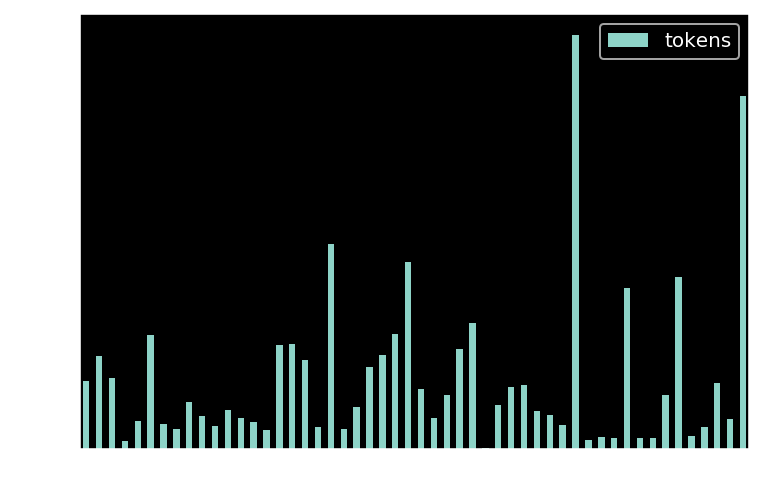

In [216]:
df_files[df_files.tokens>0.3].plot.bar(y='tokens')

In [215]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

In [209]:
help(plt)

ns=False, showextrema=True, showmedians=False, points=100, bw_method=None, *, data=None)
        Make a violin plot.
        
        Make a violin plot for each column of *dataset* or each vector in
        sequence *dataset*.  Each filled area extends to represent the
        entire data range, with optional lines at the mean, the median,
        the minimum, and the maximum.
        
        Parameters
        ----------
        dataset : Array or a sequence of vectors.
          The input data.
        
        positions : array-like, default = [1, 2, ..., n]
          Sets the positions of the violins. The ticks and limits are
          automatically set to match the positions.
        
        vert : bool, default = True.
          If true, creates a vertical violin plot.
          Otherwise, creates a horizontal violin plot.
        
        widths : array-like, default = 0.5
          Either a scalar or a vector that sets the maximal width of
          each violin. The default 